In [ ]:
########################################################################
# File       : read_czi_analyze_display_heatmap.ipynb
# Version    : 0.1
# Author     : czsrh
# Date       : 22.04.2020
# Institution : Carl Zeiss Microscopy GmbH
#
# Disclaimer: Just for testing - Use at your own risk.
# Feedback or Improvements are welcome.
########################################################################

#### Reading and CZI "Scene by Scene" and analyze the image

This notebook demonstrates how to use various open-source libraries in order to

* read CZI from an wellplate experiment "scene-by-scene"
* segment the objects
* measure the parameters
* display a heatmap using the seaborn package

In order to do so it uses (among other modules) the follwing python packages

* [PyPi - czifile](https://pypi.org/project/czifile/) - it is mainly used for reading the CZI metadata here

* [PyPi - aicsimageio](https://pypi.org/project/aicsimageio/) - this package makes use of the [libCZI](https://github.com/zeiss-microscopy/libCZI) and allows to read CZI in many different ways. Especially useful is reading in "chunks" because this way on the part of the image to be analyzed can be read.

* imagefileutils.py - This is collection of of usefule function to read CZI and OME-TFF image files. This tool uses many of the modules mentioned above
* segmentation_tools.py - This is collection of of useful functions to segment images.

***

Attention: Depending on the choice of the segmentation method one needs to install additional libaries for the machine-learning methods. For example:

* [PyPi - cellpose](https://pypi.org/project/cellpose/)
* [PyPi - TensorFlow](https://pypi.org/project/tensorflow-gpu/)

For details on how to enable those tools please refer to the instructions on the respective projects sites or documentation. **Those steps will be not covered by this notebook.**

In [2]:
import sys
sys.path.append(r'modules')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imgfileutils as imf
import segmentation_tools as sgt
import visutools as vt
from aicsimageio import AICSImage, imread
from skimage import measure, segmentation
from skimage.measure import regionprops
from skimage.color import label2rgb
import progressbar
from IPython.display import display, HTML
from MightyMosaic import MightyMosaic

The CZI image **fileformat** has many internal dimensions in order to deal with all kinds of multi-dimensional images. Internally the following dimensions exist:

Information CZI Dimension Characters:
- **0** : 'Sample',  # e.g. RGBA
- **X** : 'Width',
- **Y** : 'Height',
- **C** : 'Channel',
- **Z** : 'Slice',  # depth
- **T** : 'Time',
- **R** : 'Rotation',
- **S** : 'Scene',  # contiguous regions of interest in a mosaic image
- **I** : 'Illumination',  # direction
- **B** : 'Block',  # acquisition
- **M** : 'Mosaic',  # index of tile for compositing a scene
- **H** : 'Phase',  # e.g. Airy detector fibers
- **V** : 'View',  # e.g. for SPIM

For the example the image acquistion experiment is set up as illustrated below:

* Use wells B4-B10 for acquistion (7 wells in total)
* Use 4 independend position inside every well
* Use one channel, one timepoint and one zplane

This will result in a CZI file with 28 scenes, 4*7 for each used well B4-B10. The example CZI is pretty small, but most python libaries cannot deal with this scene structure of the CZI easily. And in case of massive CZI files the option to be able to read it "perscene" in order to limit the amount of required memory.

This can be done very nicely by the combination [libCZI](https://github.com/zeiss-microscopy/libCZI) and its Python wrapper provided by the [AICSImageIO](https://pypi.org/project/aicsimageio/) package.

<p><img src="images/96_wellplate_setup.png" title="ZEN blue - Wellplate Experiment" width="500"></p>

In [3]:
# specify the filename of the CZI file
filename = r'testdata\WP96_4Pos_B4-10_DAPI.czi'

# define platetype and get number of rows and columns
platetype = 96
nr, nc = vt.getrowandcolumn(platetype=platetype)
print(nr, nc)

8 12


In [4]:
### Define Segmentation Options - 1 ###

# define channel and size filter for objects
chindex = 0  # channel containing the objects, e.g. the nuclei in DAPI channel
minsize = 100  # minimum object size [pixel]
maxsize = 500  # maximum object size [pixel]

# optional dipslay of "some" results - empty list = no display
show_image = [0]

# toggle additional printed output
verbose = False

# set number of Scenes for testing
#SizeS = 1

In [5]:
### Define Segmentation Options - 2 ###

# threshold parameters
filtermethod = 'median'
# filtermethod = None
filtersize = 3
threshold = 'triangle'

# use watershed for splitting - ws or ws_adv
use_ws = True
ws_method = 'ws_adv'
filtersize_ws = 3
min_distance = 5
radius_dilation = 1

In [6]:
# define segmentation method 
# use_method = 'scikit'
use_method = 'cellpose'
# use_method = 'zentf'

# load the ML model from cellpose when needed
if use_method == 'cellpose':

    model = sgt.load_cellpose_model(model_type='nuclei')

    # define list of channels for cellpose
    # channels = SizeS * SizeT * SizeZ * [0, 0]
    channels = [0, 0]  # when applying it to a single image
    diameter = 30

# define model path and load TF2 model when needed
if use_method == 'zentf':

    # define tile overlap factor for MightyMosaic
    overlapfactor = 1

    # Load the model
    MODEL_FOLDER = 'model_folder'
    model, tile_height, tile_width = sgt.load_tfmodel(modelfolder=MODEL_FOLDER)
    print('ZEN TF Model Tile Dimension : ', tile_height, tile_width)

Loading Cellpose Model ...
CUDA version not installed/working, will use CPU version.
Use GPU:  False
cellpose_residual_on_style_on_concatenation_off


In [8]:
# get the metadata from the czi file
md = imf.get_metadata_czi(filename, dim2none=False)

# show some metainformation
print('------------------   Show Metainformation ------------------')

# shape and dimension entry from CZI file as returned by czifile.py
print('Array Shape (czifile)          : ', md['Shape_czifile'])
print('Dimension Entry (czifile)      : ', md['Axes_czifile'])
print('Array Shape (aicsimageio)      : ', md['Shape_aics'])
print('Dimension Entry (aicsimageio)  : ', md['Axes_aics'])
print('------------------------------------------------------------')
print('SizeS : ', md['SizeS'])
print('SizeT : ', md['SizeT'])
print('SizeZ : ', md['SizeZ'])
print('SizeC : ', md['SizeC'])
print('SizeX (czifile) : ', md['SizeX'])
print('SizeY (czifile) : ', md['SizeY'])
print('SizeY (aicsimageio) : ', md['SizeX_aics'])
print('SizeY (aicsimageio) : ', md['SizeY_aics'])
print('XScale : ', md['XScale'])
print('Yscale : ', md['YScale'])
print('Zscale : ', md['ZScale'])

Trying to extract Scene and Well information if existing ...
------------------   Show Metainformation ------------------
Array Shape (czifile)          :  (28, 1, 18764, 288764, 1)
Dimension Entry (czifile)      :  SCYX0
Array Shape (aicsimageio)      :  (28, 1, 1, 1, 640, 640)
Dimension Entry (aicsimageio)  :  STCZYX
------------------------------------------------------------
SizeS :  28
SizeT :  1
SizeZ :  1
SizeC :  1
SizeX (czifile) :  288764
SizeY (czifile) :  18764
SizeY (aicsimageio) :  640
SizeY (aicsimageio) :  640
XScale :  0.2
Yscale :  0.2
Zscale :  0.2


In [9]:
### show complete metadata

# convert metadata dictionary to a pandas dataframe
mdframe = imf.md2dataframe(md)

# and display it nicely as a HTML inside the jupyter notebook
display(HTML(mdframe.to_html()))

,Parameter,Value
0,Directory,testdata
1,Filename,WP96_4Pos_B4-10_DAPI.czi
2,Extension,czi
3,ImageType,czi
4,AcqDate,2020-04-23T09:33:58.1132508Z
5,TotalSeries,None
6,SizeX,288764
7,SizeY,18764
8,SizeZ,1
9,SizeC,1


N/A% (0 of 28) |                         | Elapsed Time: 0:00:12 ETA:  --:--:--

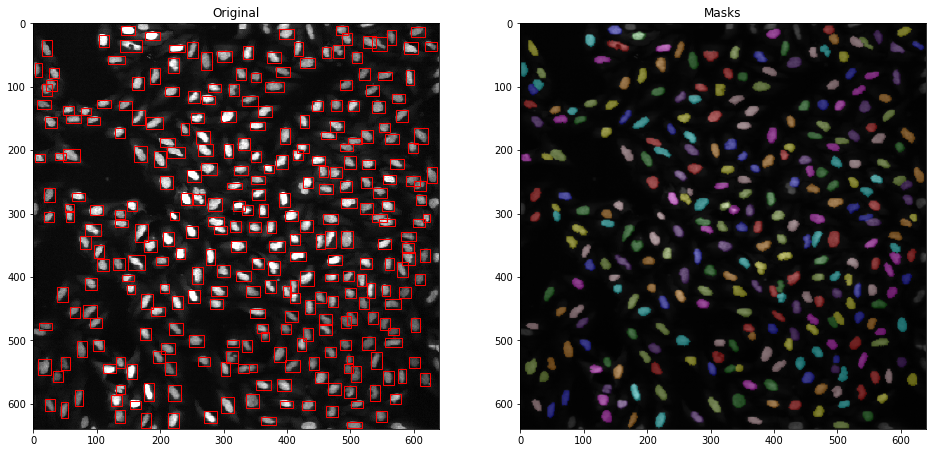

100% (28 of 28) |########################| Elapsed Time: 0:01:49 Time:  0:01:49


In [14]:
# define columns names for dataframe for the measure objects
cols = ['S', 'T', 'Z', 'C', 'Number']
objects = pd.DataFrame(columns=cols)

# set image counter to zero and create empty dataframe
image_counter = 0
results = pd.DataFrame()

###############################################################

# get AICSImageIO object using the python wrapper for libCZI
img = AICSImage(filename)

###############################################################

# loop over every scene, timepoint and zplane incl progressbar for scenes
for s in progressbar.progressbar(range(md['SizeS']), redirect_stdout=True):
    for t in range(md['SizeT']):
        for z in range(md['SizeZ']):

            # get the current plane indicies and store them
            values = {'S': s, 'T': t, 'Z': z, 'C': chindex, 'Number': 0}

            if verbose:
                print('Analyzing S-T-Z-C: ', s, t, z, chindex)
            
            # read out a single 2D image planed using AICSImageIO
            image2d = img.get_image_data("YX", S=s, T=t, Z=z, C=chindex)

            # use the cellpose package to segemnt the nuclei
            if use_method == 'cellpose':
                # get the mask for the current image
                mask = sgt.segment_nuclei_cellpose2d(image2d, model,
                                                     rescale=None,
                                                     channels=channels,
                                                     diameter=diameter,
                                                     verbose=True,
                                                     autotune=False)
            
            # use scikit-image tools to segment the nuclei
            if use_method == 'scikit':
                mask = sgt.segment_threshold(image2d,
                                             filtermethod=filtermethod,
                                             filtersize=filtersize,
                                             threshold=threshold,
                                             split_ws=use_ws,
                                             min_distance=min_distance,
                                             ws_method=ws_method,
                                             radius=radius_dilation)
            
            # use the trained U-Net from ZEN blue 3.2 using TensorFlow 2 to segment the nuclei
            if use_method == 'zentf':
                # class label for the nuclei
                classlabel = 1

                # check if tiling is required if image2d is "too big" for the network
                if image2d.shape[0] > tile_height or image2d.shape[1] > tile_width:
                    binary = sgt.segment_zentf_tiling(image2d, model,
                                                      tilesize=tile_height,
                                                      classlabel=classlabel,
                                                      overlap_factor=overlapfactor)

                # directly segment image if the size fits exactly
                elif image2d.shape[0] == tile_height and image2d.shape[1] == tile_width:
                    binary = sgt.segment_zentf(image2d, model,
                                               classlabel=classlabel)

                # use padding if the image size is "too small" for the network
                elif image2d.shape[0] < tile_height or image2d.shape[1] < tile_width:

                    # do padding
                    image2d_padded, pad = sgt.add_padding(image2d,
                                                          input_height=tile_height,
                                                          input_width=tile_width)

                    # run prediction on padded image
                    binary_padded = sgt.segment_zentf(image2d_padded, model,
                                                      classlabel=classlabel)

                    # remove padding from result
                    binary = binary_padded[pad[0]:tile_height - pad[1], pad[2]:tile_width - pad[3]]

                # apply watershed
                if use_ws:
                    if ws_method == 'ws':
                        mask = sgt.apply_watershed(binary,
                                                   min_distance=min_distance)
                    if ws_method == 'ws_adv':
                        mask = sgt.apply_watershed_adv(image2d, binary,
                                                       min_distance=min_distance,
                                                       radius=radius_dilation)
                if not use_ws:
                    # label the objects
                    mask, num_features = ndimage.label(binary)
                    mask = mask.astype(np.int)

            # clear the border by removing "touching" objects
            mask = segmentation.clear_border(mask)
            
            # define measure region properties
            to_measure = ('label',
                          'area',
                          'centroid',
                          'max_intensity',
                          'mean_intensity',
                          'min_intensity',
                          'bbox')

            # measure the specified parameters store in dataframe
            props = pd.DataFrame(
                measure.regionprops_table(
                    mask,
                    intensity_image=image2d,
                    properties=to_measure
                )
            ).set_index('label')

            # filter objects by size
            props = props[(props['area'] >= minsize) & (props['area'] <= maxsize)]

            # add well information for CZI metadata
            props['WellId'] = md['Well_ArrayNames'][s]
            props['Well_ColId'] = md['Well_ColId'][s]
            props['Well_RowId'] = md['Well_RowId'][s]

            # add plane indices
            props['S'] = s
            props['T'] = t
            props['Z'] = z
            props['C'] = chindex

            # count the number of objects
            values['Number'] = props.shape[0]
            # values['Number'] = len(regions) - 1
            if verbose:
                print('Well:', props['WellId'].iloc[0], 'Objects: ', values['Number'])

            # update dataframe containing the number of objects
            objects = objects.append(pd.DataFrame(values, index=[0]), ignore_index=True)
            results = results.append(props, ignore_index=True)

            image_counter += 1
            # optional display of results
            if image_counter - 1 in show_image:
                print('Well:', props['WellId'].iloc[0],
                      'Index S-T-Z-C:', s, t, z, chindex,
                      'Objects:', values['Number'])
                
                ax = vt.plot_segresults(image2d, mask, props, add_bbox=True)

# reorder dataframe with single objects
new_order = list(results.columns[-7:]) + list(results.columns[:-7])
results = results.reindex(columns=new_order)

In [15]:
# get a specific scene from a well
well2show = results[(results['WellId']=='B4') & (results['S']==0)]

# display the results for a specific well
display(HTML(well2show.to_html()))

,WellId,Well_ColId,Well_RowId,S,T,Z,C,area,centroid-0,centroid-1,max_intensity,mean_intensity,min_intensity,bbox-0,bbox-1,bbox-2,bbox-3
0,B4,4,2,0,0,0,0,212,10.339623,486.603774,97,58.306604,13,4,478,18,496
1,B4,4,2,0,0,0,0,273,10.842491,149.366300,176,117.135531,14,4,138,18,161
2,B4,4,2,0,0,0,0,250,12.956000,604.960000,77,50.628000,12,6,595,22,618
3,B4,4,2,0,0,0,0,276,16.500000,399.405797,116,76.065217,17,9,388,25,411
4,B4,4,2,0,0,0,0,248,20.137097,187.104839,255,162.245968,23,13,176,27,199
5,B4,4,2,0,0,0,0,230,21.443478,564.630435,80,44.256522,12,11,557,34,572
6,B4,4,2,0,0,0,0,219,25.045662,494.917808,92,57.315068,14,16,487,34,503
7,B4,4,2,0,0,0,0,260,26.715385,110.423077,158,103.234615,19,18,103,38,119
8,B4,4,2,0,0,0,0,261,29.570881,529.517241,93,60.547893,12,20,520,39,541
9,B4,4,2,0,0,0,0,201,31.258706,545.258706,76,49.323383,11,22,534,43,557


In [16]:
# display objects for every analyzed scene
display(HTML(objects.to_html()))

,S,T,Z,C,Number
0,0,0,0,0,299
1,1,0,0,0,237
2,2,0,0,0,218
3,3,0,0,0,176
4,4,0,0,0,197
5,5,0,0,0,213
6,6,0,0,0,190
7,7,0,0,0,185
8,8,0,0,0,184
9,9,0,0,0,163


In [17]:
# create heatmap array with NaNs
heatmap_numobj = vt.create_heatmap(platetype=platetype)
heatmap_param = vt.create_heatmap(platetype=platetype)

for well in md['WellCounter']:
    
    # extract all entries for specific well
    well_results = results.loc[results['WellId'] == well]

    # get the descriptive statistics for specific well
    stats = well_results.describe(include='all')

    # get the column an row indices for specific well
    col = np.int(stats['Well_ColId']['mean'])
    row = np.int(stats['Well_RowId']['mean'])

    # add value for number of objects to heatmap_numobj - e.g. "count"
    heatmap_numobj[row - 1, col - 1] = stats['WellId']['count']

    # add value for specifics params to heatmap - e.g. "area"
    heatmap_param[row - 1, col - 1] = stats['area']['mean']

df_numobjects = vt.convert_array_to_heatmap(heatmap_numobj, nr, nc)
df_params = vt.convert_array_to_heatmap(heatmap_param, nr, nc)

N/A% (0 of 28) |                         | Elapsed Time: 0:02:22 ETA:  --:--:--

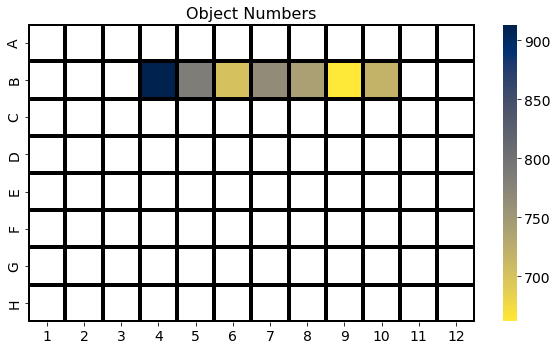

In [18]:
# define parameter to display a single heatmap
parameter2display = 'Object Numbers'
colormap = 'cividis_r'

# show the heatmap for a single parameter
savename_single = vt.showheatmap(df_numobjects, parameter2display,
                                  fontsize_title=16,
                                  fontsize_label=14,
                                  colormap=colormap,
                                  linecolor='black',
                                  linewidth=3.0,
                                  save=True,
                                  filename=filename,
                                  dpi=100)

N/A% (0 of 28) |                         | Elapsed Time: 0:02:27 ETA:  --:--:--

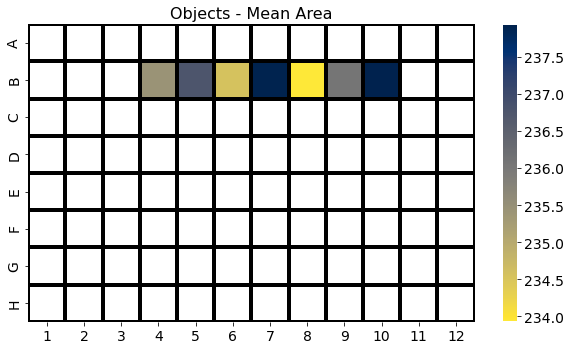

In [19]:
# define parameter to display a single heatmap
parameter2display = 'Objects - Mean Area'
colormap = 'cividis_r'

# show the heatmap for a single parameter
savename_single = vt.showheatmap(df_params, parameter2display,
                                  fontsize_title=16,
                                  fontsize_label=14,
                                  colormap=colormap,
                                  linecolor='black',
                                  linewidth=3.0,
                                  save=True,
                                  filename=filename,
                                  dpi=100)